In [1]:
import pandas as pd
import glob

In [3]:
files = glob.glob('output_gurobi/*.txt')

In [9]:
gene = [x.split('/')[1].split('_')[1] for x in files]
coenzyme = [x.split('/')[1].split('_')[2] for x in files]
stoich = [x.split('/')[1].split('_')[3].split('.')[0] for x in files]
fdata = pd.DataFrame({'file': files, 'gene': gene, 'coenzyme': coenzyme, 'stoich': stoich})

In [16]:
fdata_s = fdata[fdata['stoich'] == 'S'].sort_values('gene')
fdata_st = fdata[fdata['stoich'] == 'ST'].sort_values('gene')

In [41]:
dfs = [];
for idx,row in fdata_s.iterrows():
    df = pd.read_csv(row.file,sep='\t',index_col=0)
    df = df.set_index(['carbon','nitrogen','electron'])[['growth_rate']]
    df.columns = [row.gene]
    dfs.append(df)

In [42]:
dfs = pd.concat(dfs,axis=1)

In [45]:
dfst = [];

for idx,row in fdata_st.iterrows():
    df = pd.read_csv(row.file,sep='\t',index_col=0)
    df = df.set_index(['carbon','nitrogen','electron'])[['growth_rate']]
    df.columns = [row.gene]
    dfst.append(df)

dfst = pd.concat(dfst,axis=1)

In [67]:
thermo = (dfst.fillna(0) < 1e-7).sum() / len(dfst)
stoich = (dfs.fillna(0) < 1e-7).sum() / len(dfs)

117180

In [57]:
import seaborn as sns

In [294]:
wt_glpk = pd.read_csv('output/output/iJO1366.txt',sep='\t')[['carbon','nitrogen','electron','growth_rate']]
wt_gurobi = pd.read_csv('output_gurobi/iJO1366.txt',sep='\t')[['carbon','nitrogen','electron','growth_rate']]
wt = wt_gurobi.copy()

In [289]:
wt_glpk= wt_glpk.set_index(['carbon','nitrogen','electron']); wt_glpk.columns = ['mu (glpk)'];
wt_gurobi= wt_gurobi.set_index(['carbon','nitrogen','electron']); wt_gurobi.columns = ['mu (gurobi)'];
wts = pd.concat([wt_glpk,wt_gurobi],axis=1)

<AxesSubplot:xlabel='mu (glpk)', ylabel='mu (gurobi)'>

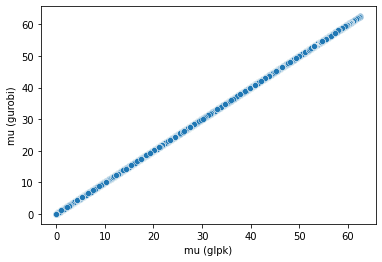

In [291]:
sns.scatterplot(x='mu (glpk)',y ='mu (gurobi)', data=wts)

In [295]:
wt.sort_values('growth_rate')['growth_rate'].iloc[6598]

0.0020915198042845513

In [296]:
cutoff = 1e-4

In [297]:
wt.set_index(['carbon','nitrogen','electron'],inplace=True)

In [298]:
wt = wt[wt['growth_rate'] > cutoff]

In [299]:
dfst = dfst.loc[wt.index]
dfs = dfs.loc[wt.index]

In [304]:
dfst.drop(columns=['growth_rate'],inplace=True); dfs.drop(columns=['growth_rate'],inplace=True)

In [305]:
dfst = dfst.join(wt)
dfs = dfs.join(wt)

In [306]:
normalized = []
genes = [x for x in list(dfst) if x != 'growth_rate']
for gene in genes:
    normalized.append(dfst[gene].values / dfst['growth_rate'].values)
    
dfst_normalized = pd.DataFrame(normalized,columns=dfst.index,index = genes).T


normalized = []
genes = [x for x in list(dfs) if x != 'growth_rate']
for gene in genes:
    normalized.append(dfs[gene].values / dfs['growth_rate'].values)
    
dfs_normalized = pd.DataFrame(normalized,columns=dfs.index,index = genes).T


In [307]:
dfst_normalized.to_hdf('relativeGrowthRates.StoichAndThermo.MR4.hdf','df')
dfs_normalized.to_hdf('relativeGrowthRates.Stoich.MR4.hdf','df')

In [315]:
#dfs_normalized.melt(value_vars=list(dfs_normalized),id_vars = dfs_normalized.index)
dfn_s_skinny = pd.melt(dfs_normalized.reset_index(), id_vars=['carbon','nitrogen','electron'], value_vars=list(dfs_normalized))
dfn_st_skinny = pd.melt(dfst_normalized.reset_index(), id_vars=['carbon','nitrogen','electron'], value_vars=list(dfst_normalized))


In [317]:
dfn_s_skinny.columns = ['carbon','nitrogen','electron','gene','relative growth rate (stoich)']
dfn_st_skinny.columns = ['carbon','nitrogen','electron','gene','relative growth rate (stoich+thermo)']


In [319]:
idx_vars = ['carbon','nitrogen','electron','gene']
dfn = pd.concat([dfn_s_skinny.set_index(idx_vars),dfn_st_skinny.set_index(idx_vars)],axis=1);

<AxesSubplot:xlabel='relative growth rate (stoich)', ylabel='relative growth rate (stoich+thermo)'>

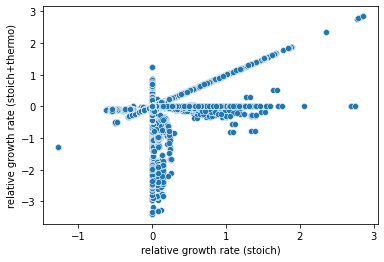

In [322]:
sns.scatterplot(x='relative growth rate (stoich)',y='relative growth rate (stoich+thermo)',data=dfn.apply(np.log10))

In [152]:
q = 1 - (dfst_normalized < cutoff).sum() / len(dfst_normalized)

In [154]:
q.sort_values()

b2320    0.00000
b0073    0.00000
b4358    0.99989
b2799    0.99989
b2091    0.99989
          ...   
b1479    1.00000
b1444    1.00000
b1415    1.00000
b4323    1.00000
b2052    1.00000
Length: 76, dtype: float64

In [158]:
g = (dfst_normalized < cutoff).sum() > 0

In [163]:
g2

b0031    False
b0052    False
b0073    False
b0104    False
b0116    False
         ...  
b3972    False
b4266    False
b4267    False
b4323    False
b4358    False
Length: 76, dtype: bool

In [160]:
g2 = (dfs_normalized < cutoff).sum() > 0
g2[g2]

Series([], dtype: bool)

In [185]:
dfst_normalized[dfst_normalized['b1779'] < 1e-3].reset_index().electron.unique()

array(['None'], dtype=object)

In [189]:
dfs_normalized.min().sort_values()

b1761    0.053181
b3608    0.236107
b2463    0.308905
b3236    0.465973
b1539    0.555511
           ...   
b4267    1.000000
b0414    1.000000
b0031    1.000000
b0116    1.000000
b1014    1.000000
Length: 76, dtype: float64

In [193]:
h = pd.DataFrame(dfst_normalized.min().sort_values(),columns = ['st']).join(pd.DataFrame(dfs_normalized.min().sort_values(),columns = ['s']))

<AxesSubplot:ylabel='st'>

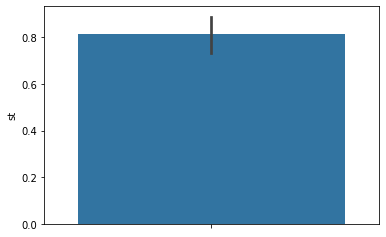

In [197]:
sns.barplot(data=h,y='st')

<AxesSubplot:xlabel='s', ylabel='st'>

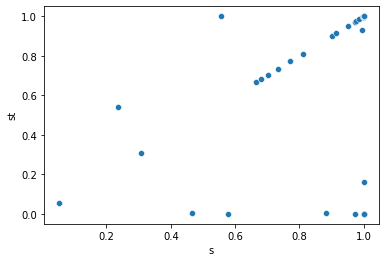

In [199]:
sns.scatterplot(x='s',y='st',data=h)

In [202]:
h.head(15)

,st,s
b4358,0.000000,0.999999
b0073,0.000000,1.000000
b2091,0.000000,0.999999
b2320,0.000000,1.000000
b1395,0.000000,0.999999
b2799,0.000000,0.578059
b1779,0.000401,0.974607
b1136,0.004723,0.884284
b3236,0.006426,0.465973
b1761,0.053181,0.053181


In [324]:
h[h['st'] < 0.05]

,st,s
b4358,0.000000,0.999999
b0073,0.000000,1.000000
b2091,0.000000,0.999999
b2320,0.000000,1.000000
b1395,0.000000,0.999999
b2799,0.000000,0.578059
b1779,0.000401,0.974607
b1136,0.004723,0.884284
b3236,0.006426,0.465973


In [326]:
gs = pd.read_csv('../assets/mutantGeneSet.reactionDirectionUpdateRules.MR4.csv')

In [331]:
h[h['st'] < 0.05].join(gs.set_index('gene')).sort_values('st')

,st,s,Unnamed: 0,reaction,gene_name,deltaG_prime_m,deltaG_prime_m (error),wild type coenzyme,mutant coenzyme,max_deltaG (WT),min_deltaG (WT),max_deltaG (mutant),min_deltaG (mutant),direction (wild type),direction (mutant)
b0073,0.000000,1.000000,54,IPMD,leuB,16.222572,0.986231,NAD(H),NADP(H),30.516026,-15.148050,49.083366,3.419290,reversible,irreversible (backward)
b1395,0.000000,0.999999,47,HADPCOADH3,paaH,16.214254,0.986231,NAD(H),NADP(H),30.507707,-15.156369,49.075047,3.410971,reversible,irreversible (backward)
b2091,0.000000,0.999999,38,GLTPD,gatD,13.603320,1.196836,NAD(H),NADP(H),27.896774,-17.767302,46.464114,0.800038,reversible,irreversible (backward)
b2320,0.000000,1.000000,75,PERD,pdxB,16.227662,0.986231,NAD(H),NADP(H),30.521115,-15.142961,49.088455,3.424379,reversible,irreversible (backward)
b2799,0.000000,0.578059,59,LCARS,fucO,-24.005813,1.501614,NAD(H),NADP(H),7.364809,-38.299267,-11.202530,-56.866606,reversible,irreversible (forward)
b4358,0.000000,0.999999,33,GALCTLO,lgoD,15.807193,1.441710,NAD(H),NADP(H),30.100647,-15.563429,48.667987,3.003911,reversible,irreversible (backward)
b1779,0.000401,0.974607,34,GAPD,gapA,18.922609,0.405626,NAD(H),NADP(H),67.464119,-1.031995,86.031459,17.535345,reversible,irreversible (backward)
b1136,0.004723,0.884284,50,ICDHyr,icd,-11.699982,3.186777,NADP(H),NAD(H),9.744793,-58.751321,-8.822547,-77.318661,reversible,irreversible (forward)
b3236,0.006426,0.465973,64,MDH,mdh,27.098390,0.304888,NAD(H),NADP(H),41.391844,-4.272232,59.959184,14.295108,reversible,irreversible (backward)


In [357]:
z = pd.DataFrame((dfst_normalized <  0.1).sum().sort_values()).join(gs[['gene','gene_name']].drop_duplicates().set_index('gene')).reset_index()

In [358]:
z

,index,0,gene_name
0,b0031,0,dapB
1,b3365,0,nirB
2,b3213,0,gltD
3,b2913,0,serA
4,b2867,0,xdhB
...,...,...,...
71,b1136,54,icd
72,b1395,170,paaH
73,b1779,662,gapA
74,b0073,109521,leuB


In [359]:
z.columns = ['gene','N','gene name']

In [351]:
import matplotlib.pyplot as plt

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 [Text(0, 0, 'dapB'),
  Text(1, 0, 'nirB'),
  Text(2, 0, 'gltD'),
  Text(3, 0, 'serA'),
  Text(4, 0, 'xdhB'),
  Text(5, 0, 'queF'),
  Text(6, 0, 'cysJ'),
  Text(7, 0, 'cysG'),
  Text(8, 0, 'srlD'),
  Text(9, 0, 'hcaD'),
  Text(10, 0, 'hcaB'),
  Text(11, 0, 'guaB'),
  Text(12, 0, 'maeB'),
  Text(13, 0, 'arnA'),
  Text(14, 0, 'preT'),
  Text(15, 0, 'tyrA'),
  Text(16, 0, 'uxuB'),
  Text(17, 0, 'asd'),
  Text(18, 0, 'ghrB'),
  Text(19, 0, 'idnD'),
  Text(20, 0, 'idnO'),
  Text(21, 0, 'murB'),
  Text(22, 0, 'argC'),
  Text(23, 0, 'gldA'),
  Text(24, 0, 'metF'),
  Text(25, 0, 'gor'),
  Text(26, 0, 'yihU'),
  Text(27, 0, 'wecC'),
  Text(28, 0, 'ilvC'),

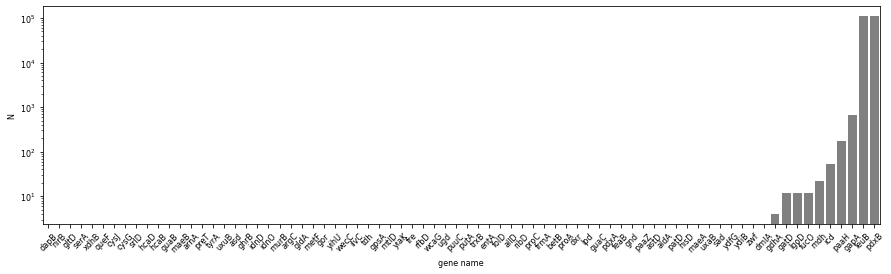

In [367]:
a4_dims = (15, 4)
fig, ax = plt.subplots(figsize=a4_dims)
plt.rcParams.update({'font.size': 8})
sns.barplot(x='gene name',y='N',data=z,color='grey')
plt.yscale('log')
plt.xticks(rotation=45)

/Users/Joshua.Goldford/opt/miniconda3/envs/coenzyme_paper/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='b1395', ylabel='Density'>

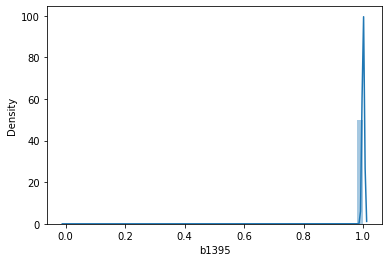

In [231]:
sns.distplot(dfst_normalized['b1395'])

In [233]:
thermo = pd.read_csv('../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')

In [265]:
thermo[thermo.gene.isin(['b2705'])]

,reaction,gene,gene_name,deltaG_prime_m,deltaG_prime_m (error)
80,SBTPD,b2705,srlD,12.058504,1.734759


In [236]:
import cobra

In [266]:
model = cobra.io.read_sbml_model('../assets/models/stoich_thermo/iJO1366_b2705_NADP.xml')

In [267]:
model.reactions[-1]

Reaction identifier,SBTPD[mutant]
Name,Sorbitol-6-phosphate dehydrogenase
Memory address,0x07f8e6f5fdf40
Stoichiometry,nadp_c + sbt6p_c <=> f6p_c + h_c + nadph_c Nicotinamide adenine dinucleotide phosphate + D-Sorbitol 6-phosphate <=> D-Fructose 6-phosphate + H+ + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,b2705
Lower bound,-1000.0
Upper bound,1000.0


In [268]:
model_wt = cobra.io.read_sbml_model('../assets/iJO1366.xml')

In [269]:
[x for x in model_wt.reactions if x.id == 'SBTPD'][0]

Reaction identifier,SBTPD
Name,Sorbitol-6-phosphate dehydrogenase
Memory address,0x07f8e7067d520
Stoichiometry,nad_c + sbt6p_c <=> f6p_c + h_c + nadh_c Nicotinamide adenine dinucleotide + D-Sorbitol 6-phosphate <=> D-Fructose 6-phosphate + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,b2705
Lower bound,-1000.0
Upper bound,1000.0


In [270]:
RT = 8.31446261815324 * 10**-3 * 298.15



In [246]:
import numpy as np

In [261]:
12.058504 + RT * np.log((1.2e-4 * 1e-6) / (2.1e-6 * 1e-2 *1) )

3.424379503550485

In [263]:
16.227662 - 3.424379503550485

12.803282496449514

In [ ]:
def get_concentrations(x,metConc):
    if x == 'bigg.metabolite:nad':
        return 2.6e-3
    elif x == 'bigg.metabolite:nadh':
        return 8.3e-5
    elif x == 'bigg.metabolite:nadp':
        return 2.1e-6
    elif x == 'bigg.metabolite:nadph':
        return 1.2e-4
    elif x in ['bigg.metabolite:h','bigg.metabolite:h2o']:
        return 1
    else:
        return metConc